# BERT MODEL

# Reading Files

In [ ]:
import pandas as pd
from PIL import Image
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive')
import os
import time
import torch

Mounted at /content/drive


In [ ]:
# Define the data directory and output directory
input_directory = '/content/drive/MyDrive/deneme/'

# Read the dataframe
df = pd.read_csv(os.path.join(input_directory, 'combined_train.csv'))

# Specify the column names we want to keep
columns_to_keep = ['clean_comments', 'scenic']

# Keep only the specified columns
df = df[columns_to_keep]

df_new = df[df['clean_comments'].notnull()]
df_new2= df_new[df_new['scenic'].notnull()]

In [ ]:
df.head()

,clean_comments,scenic
0,northern end long mountain,0
1,looking north,1
2,old railway line used farm road remnant previo...,0
3,clump tree teampan,1
4,looking north west,0


In [ ]:
print(len(df),len(df_new),len(df_new2))
df=df_new2

8000 8000 8000


In [ ]:
df.reset_index(inplace=True)

# Rename the 'index' column to 'id'
df.rename(columns={'index': 'id'}, inplace=True)

# Print the updated dataframe
print(df)

        id                                     clean_comments  scenic
0        0                         northern end long mountain       0
1        1                                      looking north       1
2        2  old railway line used farm road remnant previo...       0
3        3                                 clump tree teampan       1
4        4                                 looking north west       0
...    ...                                                ...     ...
7995  7995  golfer enjoying round golf move fairway next shot       0
7996  7996  national grid substation distance next square ...       0
7997  7997  like [ [ 7143 ] ] footpath 562151 go nowhere a...       0
7998  7998  bridleway start long road cross fairly level g...       1
7999  7999  track right go farm think house picture nothin...       0

[8000 rows x 3 columns]


# Test-Train Split

In [ ]:
# Define the data directory and output directory
input_directory = '/content/drive/MyDrive/deneme/'

# Read the dataframe
df_test = pd.read_csv(os.path.join(input_directory, 'combined_train.csv'))
df_validation = pd.read_csv(os.path.join(input_directory, 'combined_val.csv'))
df_train=df

train_text= df_train['clean_comments'].values
test_text= df_test['clean_comments'].values
val_text=df_validation['clean_comments'].values

train_labels= df_train['scenic'].values
test_labels= df_test['scenic'].values
val_label= df_validation['scenic'].values


# Bert- Base -Uncased Model

We’ll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained("bert-base-uncased")

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Tokenizing the first text as an example.

In [ ]:
# Print the original sentence.
print(' Original: ', train_text[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))

 Original:  northern end long mountain
Tokenized:  ['northern', 'end', 'long', 'mountain']
Token IDs:  [2642, 2203, 2146, 3137]


In [ ]:
max_word_count = max([len(text.split()) for text in train_text])
print("Maximum word count:", max_word_count)

Maximum word count: 201


#Tokenising

- To avoid subword parameter we split the text first.  

- In this example, the tokenizer.encode method is modified to include padding using the padding='max_length' argument and specifying a maximum length of 64 tokens (max_length=64). The torch.tensor conversion ensures that all sequences have the same length by padding them with zeros.  

- Truncation used to shortening a text to the length. This is necessary because models  require input size of 100. If a text is too long, it is going to be truncated. After, by padding all other texts to max_length we making sure that all texts are in the same length.

In [ ]:
# Word-level tokenization using whitespace tokenizer
train_tokens_word_level = [text.split()[:364] for text in train_text]

# BERT tokenization on word-level tokens
train_tokens_bert = [tokenizer.encode(text, truncation=True, padding='max_length', max_length=100) for text in train_tokens_word_level]

train_tokens_before_padding = [tokenizer.encode(text, truncation=True, padding=True) for text in train_tokens_word_level]

In [ ]:
# Print the sentence split into tokens.
print('Sentence: ', train_text[1000])

# Print the sentence mapped to token ids.
print('Tokens: ', train_tokens_bert[1000])

Sentence:  pair heavy horse dwarf shetland pony croft west town baras
Tokens:  [101, 3940, 3082, 3586, 11229, 25552, 15606, 28983, 2225, 2237, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Choosing "max_length"

Since significant amount of text less then 100 words, we chosed 100 as padding length.

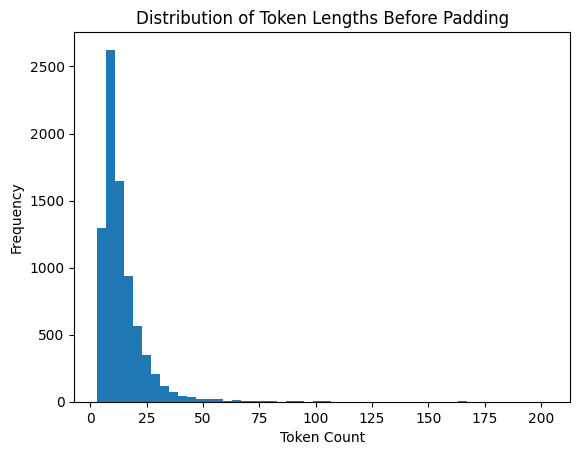

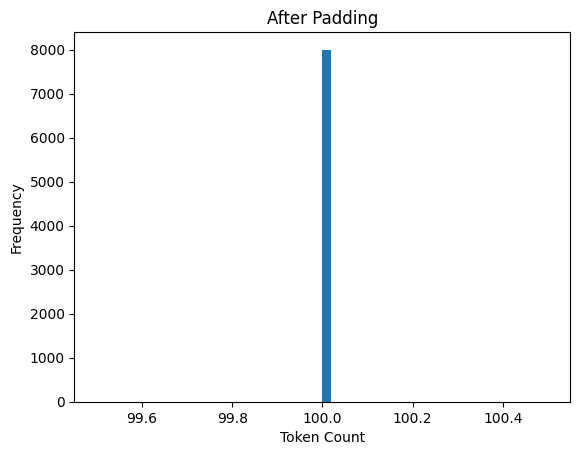

In [ ]:
# Calculate the lengths of tokenized sequences
token_lengths_after_padding = [len(tokens) for tokens in train_tokens_bert]
token_lengths_before_padding = [len(tokens) for tokens in train_tokens_before_padding]

plt.hist(token_lengths_before_padding, bins=50)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths Before Padding')
plt.show()

# Plot the distribution of token lengths after padding
plt.hist(token_lengths_after_padding, bins=50)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('After Padding')
plt.show()

# PREPEARING THE TOKENS/ TEST-TRAIN INPUTS

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

train_inputs = {
    'input_ids': torch.tensor([tokens for tokens in train_tokens_bert]),
    #'attention_mask': torch.tensor([[1] * len(tokens) for tokens in train_tokens]),
    'labels': torch.tensor(train_labels)
}

In [ ]:
# Word-level tokenization using whitespace tokenizer
test_tokens_word_level = [text.split()[:364] for text in test_text]

# BERT tokenization on word-level tokens
test_tokens_bert = [tokenizer.encode(text, truncation=True, padding='max_length', max_length=100) for text in test_tokens_word_level]

test_inputs = {
    'input_ids': torch.tensor([tokens for tokens in test_tokens_bert]),
    #'attention_mask': torch.tensor([[1] * len(tokens) for tokens in test_tokens]),
    'labels': torch.tensor(test_labels)
}

# Creating Dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs['input_ids'], train_inputs["labels"])
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(test_inputs['input_ids'], test_inputs["labels"])
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#  MODEL PARAMETERS

We’ll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier

In [ ]:
! pip install transformers

In [ ]:
#Loading the pre-trained BERT model from huggingface library

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = True,
    # each input token in relation to other tokens during the model's processing
    output_hidden_states = False, )

# Teeling the model to run on GPU
#model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

In [ ]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# LEARNING RATE SCHEDULER

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# ACCURACY FUNTION AND TIMING

In [ ]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#Creating the helper function to have a watch on elapsed time
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# MODEL TRAINING

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seeds = 42

random.seed(seeds)
np.random.seed(seeds)
torch.manual_seed(seeds)
torch.cuda.manual_seed_all(seeds)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        #b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)

        # Always clear any previously calculated gradients before performing aforward pass
        model.zero_grad()

        outputs = model(b_input_ids,
                    token_type_ids=None,
                    #attention_mask=b_input_mask,
                    labels=b_labels)

        # loss value out of the tuple.
        loss = outputs[0]
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

# in this part we use validation_dataset for validation. separate datset !!!!!!!!!

    # Evaluate data for one epoch
    for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      #b_input_mask = batch[1].to(device)
      b_labels = batch[1].to(device)
      # speeding up validation
      with torch.no_grad():
          outputs = model(b_input_ids,
                            token_type_ids=None,
                            #attention_mask=b_input_mask
                          )
      logits = outputs[0]
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_eval_accuracy = flat_accuracy(logits, label_ids)
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

      print("  Accuracy is: {0:.2f}".format(eval_accuracy/nb_eval_steps))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training is done!")

In [ ]:
print(loss_values)

[0.5426663517355919, 0.41393415212631224, 0.34579006224870684, 0.2817151550650597, 0.23124317288398744]


# Save The Model

In [ ]:
# Define the path for saving the model
model_path = '/content/drive/MyDrive/deneme/bert_8k'

# Save the model
model.save_pretrained(model_path)

# Prediciton

For prediction we will use val_text dataset which we didn't touch since the beginning.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
#print(train_inputs['labels'])
print(test_labels)

[0 1 0 ... 0 1 0]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Word-level tokenization using whitespace tokenizer
test_tokens_word_level = [text.split()[:364] for text in val_text]

# BERT tokenization on word-level tokens
test_tokens_bert = [tokenizer.encode(text, truncation=True, padding='max_length', max_length=100) for text in test_tokens_word_level]

test_inputs = {
    'input_ids': torch.tensor([tokens for tokens in test_tokens_bert]).to(device),
    #'attention_mask': torch.tensor([[1] * len(tokens) for tokens in test_tokens]),
    'labels': torch.tensor(val_label).to(device)
    #'labels': torch.tensor(test_labels.values)  # Convert test_labels to a numpy array using the 'values' attribute
}

In [ ]:
len(test_inputs['input_ids'])

1000

In [ ]:
import time

batch_size = 16
outputs = []

# Set the model to evaluation mode
model.eval()

# Move the model to the same device as the input tensors (if not already on the same device)
model.to(device)
# Get the number of batches
num_batches = len(test_inputs['input_ids']) // batch_size
# Start the timer
start_time = time.time()

for i in range(0, len(test_inputs['input_ids']), batch_size):
    batch_inputs = {
        'input_ids': test_inputs['input_ids'][i:i+batch_size].to(device)
                   }
    with torch.no_grad():
        batch_output = model(**batch_inputs)
        outputs.extend(batch_output.logits.cpu().numpy())

    # Calculate elapsed time for this batch
    elapsed_time = time.time() - start_time
    # Calculate estimated total time
    estimated_total_time = elapsed_time / (i + 1) * num_batches
    # Print the estimated time for completion after each batch
    print(f"Batch {i//batch_size + 1}/{num_batches}, Estimated Total Time: {estimated_total_time:.2f} seconds")

# End of inference
print("Inference completed!")

#CONFUSION MATRIX AND ACCURACY SCORES

In [ ]:
import numpy as np

In [ ]:
predicted_labels = np.argmax(outputs, axis=1)  # Convert logits to class labels
true_labels = val_label  # test_labels is a numpy array or list of true labels

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

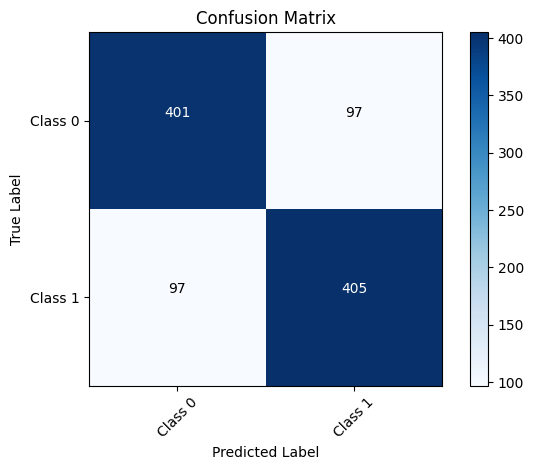

Accuracy: 0.81


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations for TP, TN, FP, FN counts
    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f'{cm[i, j]}\n', ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# we have a list of class names 'class_names'
class_names = ['Class 0', 'Class 1']  # Replace with our actual class names
plot_confusion_matrix(cm, class_names)
plt.show()

print(f"Accuracy: {accuracy:.2f}")

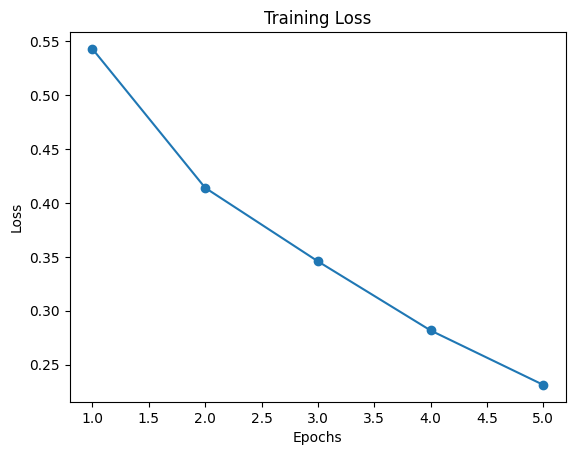

In [ ]:
# Plotting the loss
epochs = range(1, epochs+1)

plt.plot(epochs, loss_values, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1_score(true_labels, predicted_labels, average='macro')

f1_score(true_labels, predicted_labels, average='micro')

f1_score(true_labels, predicted_labels, average='weighted')

f1_score(true_labels, predicted_labels, average=None)

array([0.80522088, 0.80677291])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       498
           1       0.81      0.81      0.81       502

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

